In [2]:
# 🚀 **Importing Helper Modules**

import torch  # 🧠 Core PyTorch library for tensor operations and neural networks
import torch.nn as nn  # 🏗️ Neural network components (layers, loss functions)
import torch.optim as optim  # ⚙️ Optimization algorithms (SGD, Adam, etc.)
import torchvision  # 🎨 Computer vision utilities and datasets
import torchvision.transforms as transforms  # 🖼️ Data transformations (normalization, augmentation)
from torch.utils.data import DataLoader  # 🚚 For loading and batching data
import matplotlib.pyplot as plt  # 📊 Visualization for losses and accuracies
from torchvision.transforms import ToTensor
from torchvision import datasets
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [24]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

def load_mnist_data(batch_size=64):
    """
    📦 Load and preprocess the MNIST dataset.
    📜 Returns: train_loader and test_loader 🎯
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # 🔄 Resize images to 224x224 pixels
        transforms.ToTensor(),  # 🔄 Convert images to tensors 📊
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # 🌈 Convert grayscale to RGB
        transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081))  # ⚖️ Normalize for RGB
        #transforms.Normalize((0.1307,), (0.3081,)) #normalize for grayscale
    ])

    # 🛠️ Load MNIST training and test datasets 🖼️
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader  # 🚚 Return the loaders 📦


In [25]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2: conv3-128 -> conv3-128 -> maxpool
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3: conv3-256 -> conv3-256 -> maxpool
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4: conv3-512 -> conv3-512 -> maxpool
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5: conv3-512 -> conv3-512 -> maxpool
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Calculate flattened size for Linear layer input
        self.flattened_size = 512 * 7 * 7

        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Linear(self.flattened_size, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)  # Flatten all dimensions except batch
        x = self.classifier(x)
        return x


In [26]:
# 🚀 **Part 5: Training Functions**

def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    🛠️ TODO: Implement training loop for one epoch 🏋️‍♂️
    """
    model.train()  # 📈 Switch to training mode
    running_loss = 0.0  # 💰 Track the cumulative loss
    correct = 0  # ✅ Correct predictions counter
    total = 0  # 📊 Total samples counter

    for data, target in train_loader:  # 🔄 Loop through batches
        # 📌 Your code here (e.g., forward pass, loss calculation, backward pass, optimizer step)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    # 📊 Return average loss and accuracy for the epoch
    return running_loss / len(train_loader), 100. * correct / total

def evaluate(model, test_loader, criterion, device):
    """
    🧪 TODO: Implement evaluation loop 🔍
    """
    model.eval()  # 🔕 Switch to evaluation mode (no gradients)
    test_loss = 0  # 💰 Track cumulative test loss
    correct = 0  # ✅ Correct predictions counter
    total = 0  # 📊 Total samples counter

    with torch.no_grad():  # 🚫 No gradient calculation for evaluation
        # 📌 Your code here (e.g., forward pass, loss calculation, accuracy calculation)
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            test_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    # 📊 Return average test loss and accuracy
    return test_loss / len(test_loader), 100. * correct / total


In [27]:
# 🚀 **Part 6: Main Training Loop**

def main():
    # ⚙️ **Hyperparameters**
    BATCH_SIZE = 16  # 📦 Batch size for data loading
    EPOCHS = 3  # 🔄 Number of training epochs
    LEARNING_RATE = 0.001  # 🚀 Learning rate for optimizer
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # ⚡ Use GPU if available

    # 📊 **Load data**
    train_loader, test_loader = load_mnist_data(BATCH_SIZE)

    # 🛠️ **Initialize model, criterion, optimizer**
    model = VGG16().to(DEVICE)  # 🖥️ Move model to the selected device
    criterion = nn.CrossEntropyLoss()  # 🎯 Loss function for classification
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)  # 🚀 Adam optimizer for better convergence

    # 🔄 **Training loop**
    train_losses = []  # 📉 Track training losses
    test_losses = []  # 📉 Track test losses
    train_accs = []  # 📊 Track training accuracy
    test_accs = []  # 📊 Track test accuracy

    for epoch in range(EPOCHS):
        # 🏋️‍♂️ **TODO: Implement main training loop**
        print(f"🌟 Epoch {epoch+1}/{EPOCHS}")

        # Train for one epoch
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Evaluate on test set
        test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        # Print progress
        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.2f}%, Test Loss = {test_loss:.4f}, Test Acc = {test_acc:.2f}%")

    # 📈 **Plot results**
    # 🛠️ **TODO: Create loss and accuracy plots**
    # Example: plt.plot(train_losses), plt.plot(test_losses), etc.
    epochs_range = range(1, EPOCHS+1)
    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, test_losses, label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs_range)
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label='Train Accuracy')
    plt.plot(epochs_range, test_accs, label='Test Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.xticks(epochs_range)
    plt.legend()

    plt.tight_layout()
    plt.show()

🌟 Epoch 1/3
Epoch 1: Train Loss = 1.1584, Train Acc = 65.49%, Test Loss = 0.1552, Test Acc = 96.59%
🌟 Epoch 2/3
Epoch 2: Train Loss = 0.2261, Train Acc = 93.90%, Test Loss = 0.0696, Test Acc = 98.19%
🌟 Epoch 3/3
Epoch 3: Train Loss = 0.1244, Train Acc = 96.89%, Test Loss = 0.0489, Test Acc = 98.51%


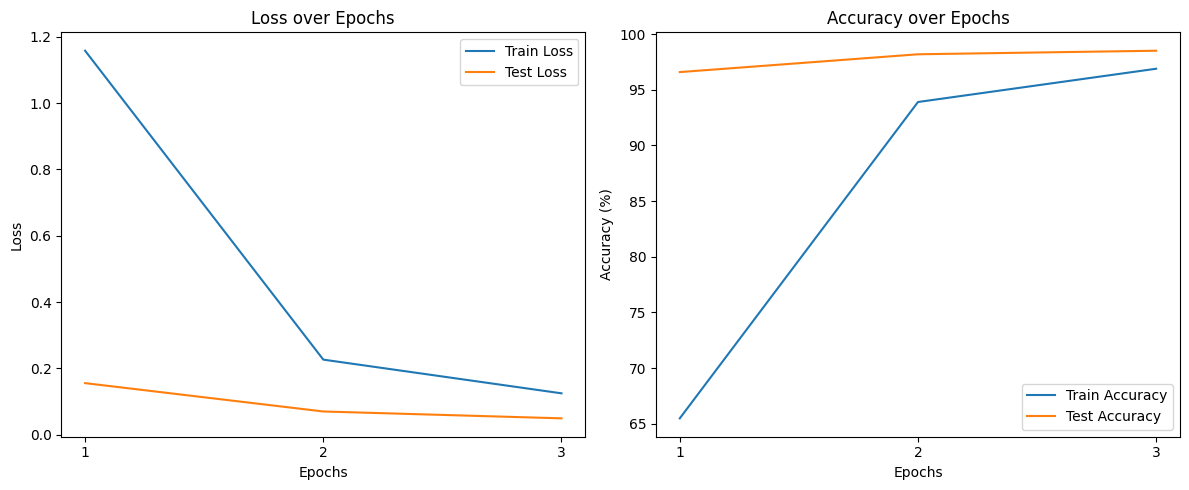

In [28]:
if __name__ == '__main__':
    main()